In [1]:
import argparse
import gc
import logging
import os
import sys
import time

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim

from sgan.data.loader import data_loader
from sgan.losses import gan_g_loss, gan_d_loss, l2_loss
from sgan.losses import displacement_error, final_displacement_error

from sgan.models import TrajectoryGenerator, TrajectoryDiscriminator
from sgan.utils import int_tuple, bool_flag, get_total_norm
from sgan.utils import relative_to_abs, get_dset_path
from sgan.various_length_models import LateAttentionFullGenerator
from sgan.semantic_models import feature_extractor, SemanticAttentionGenerator

In [2]:
from easydict import EasyDict as edict
args = edict({'obs_len': 8, 'pred_len': 12, 'skip': 1, 'delim': '\t', 'batch_size': 1,'loader_num_workers': 0})
dset_name = "bookstore"
__, dataloader = data_loader(args, dset_name)

loaded image: /home/asus/SemanticSocialNavigation/datasets/bookstore/video0/reference.jpg
resized channel,resized_h, resized_w and ratio: torch.Size([3, 512, 512]) 0.359550561798
loaded image: /home/asus/SemanticSocialNavigation/datasets/bookstore/video1/reference.jpg
resized channel,resized_h, resized_w and ratio: torch.Size([3, 512, 512]) 0.36005625879
loaded image: /home/asus/SemanticSocialNavigation/datasets/bookstore/video2/reference.jpg
resized channel,resized_h, resized_w and ratio: torch.Size([3, 512, 512]) 0.36005625879
loaded image: /home/asus/SemanticSocialNavigation/datasets/bookstore/video3/reference.jpg
resized channel,resized_h, resized_w and ratio: torch.Size([3, 512, 512]) 0.387291981846
loaded image: /home/asus/SemanticSocialNavigation/datasets/bookstore/video4/reference.jpg
resized channel,resized_h, resized_w and ratio: torch.Size([3, 512, 512]) 0.387291981846
loaded image: /home/asus/SemanticSocialNavigation/datasets/bookstore/video5/reference.jpg
resized channel,r

In [33]:
# from IPython.display import clear_output
# from torchvision import transforms, utils
# import matplotlib.pyplot as plt
# import numpy as np

# inv_normalize = transforms.Normalize(
#     mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
#     std=[1/0.229, 1/0.224, 1/0.255]
# )


# for i_batch, sample_batched in enumerate(dataloader):
    
#     (obs_traj, pred_traj, __,__, __,loss_mask, __, __, __, img_list,pointer_to_image) = sample_batched

#     pointer_to_image = pointer_to_image[0].numpy()
#     img_list = img_list[0]  
#     obs_traj = obs_traj.numpy()
#     pred_traj = pred_traj.numpy()

#     for i in range(obs_traj.shape[0]):
#         img = img_list[int(pointer_to_image[0,i])]
#         img = inv_normalize(img)
        
#         traj = obs_traj[i,:,:]
#         fig = plt.figure(figsize=(20,10))
#         clear_output(wait=True)
#         plt.imshow(np.transpose(img, (1,2,0)))
#         plt.scatter(traj[:,0],traj[:,1],s=10,marker='.',c='r')
#         fig.canvas.draw()
#         plt.pause(0.25)

In [3]:
img_size = 512 
img_embeded_dim = 1024
model = feature_extractor(img_size,img_embeded_dim)
model.cuda()
model.eval()

for i_batch, sample_batch in enumerate(dataloader):
    (__, __, __,__, __,__, __, __, __, img_list,pointer_to_image) = sample_batch
    
    pointer_to_image = pointer_to_image[0][0][0].cuda()
    img = img_list[0][pointer_to_image.item()].cuda()
    img = img.view(1, *img.size())
    tmp,c1,c2,c3 = model(img)
    break


In [4]:
print(type(tmp))
print(tmp.size())

<class 'torch.Tensor'>
torch.Size([1, 1024])


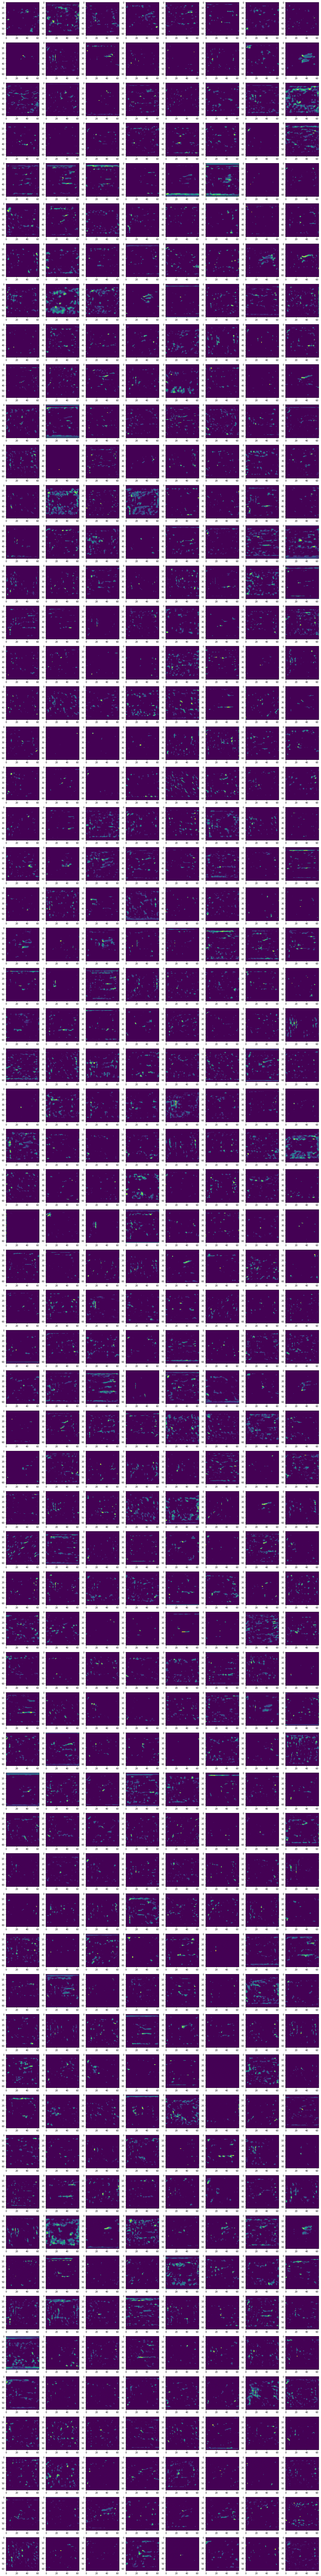

In [55]:
import matplotlib.pyplot as plt
layer_0 = tmp[1].cpu().detach().numpy()
layer_0 = layer_0[0]
fig = plt.figure(figsize=(20, 160))
n = layer_0.shape[0]
for i in range(n):
    patch = layer_0[i,:,:]
    sub = fig.add_subplot(64, 8, i + 1)
    sub.imshow(patch, interpolation='nearest')
    
plt.tight_layout()   

In [54]:
print len(tmp)
print tmp[2].shape

3
torch.Size([1, 512, 32, 32])


In [11]:
torch.__version__

'1.1.0'